# Golden Cross

## Indicators
- Fast Moving Average
- Slow Moving Average
- FMA - SMA

## Signals
- True/False
- Factor Variables
    - For some Time Intervals
    
- Bullish Signal
    - if FMA > SM: N=1 (Buy one lots of stock)
- Bearish Signal
    - if FMA < SM: N=-1 (Sell one lots of stock)
    

In [1]:
## Load the libraries required
# update.packages()
library(TTR)
library(zoo)
library(Quandl)
library(quantmod)
library(blotter)


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: xts
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: FinancialInstrument
Loading required package: PerformanceAnalytics

Attaching package: ‘PerformanceAnalytics’

The following object is masked from ‘package:graphics’:

    legend



In [2]:
## Get Stock data from Quandl
P<-Quandl("GOOG/NYSE_SPY")
P<-zoo(P[,2:5], as.Date(P[,1]))

tail(P)

             Open   High    Low  Close
2016-09-30 215.65 217.12 215.36 216.30
2016-10-03 215.82 216.04 215.04 215.78
2016-10-04 215.91 216.17 213.99 214.68
2016-10-05 215.41 216.13 215.33 215.63
2016-10-06 215.37 216.04 214.74 215.78
2016-10-07 216.10 216.30 214.19 215.04

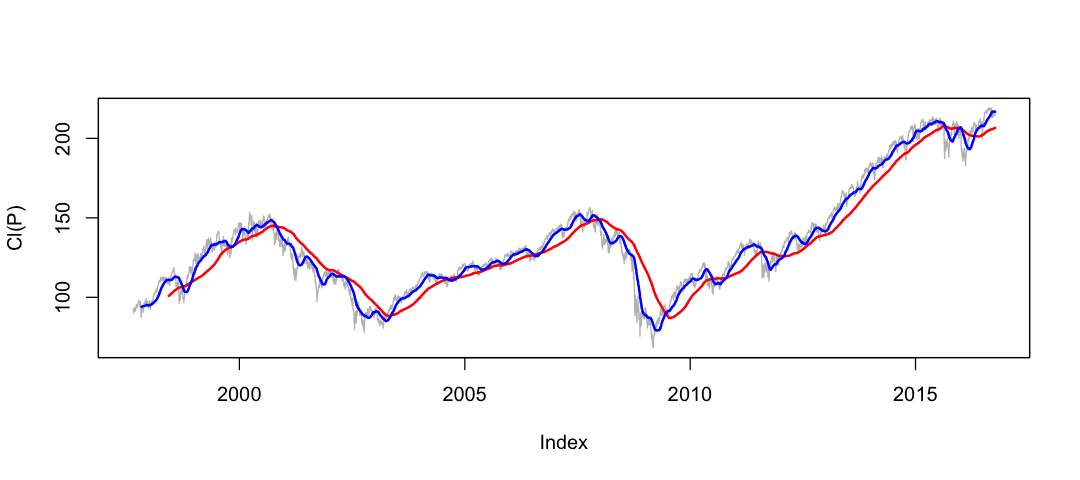

In [3]:
# Define Moving Averages
MA.Slow<-SMA(x=Cl(P), n=200)
MA.Fast<-SMA(x=Cl(P), n=50)

# plotting size settings
options(repr.plot.width=9, repr.plot.height=4)

# Plot Price and MAs
plot(Cl(P), col="grey")
lines(MA.Slow, col="red", lwd=2)
lines(MA.Fast, col="blue", lwd=2)
# legend("topleft", c("Price", "Slow MA", "Fast MA"), text.col=c(1,2,4),bty="n")

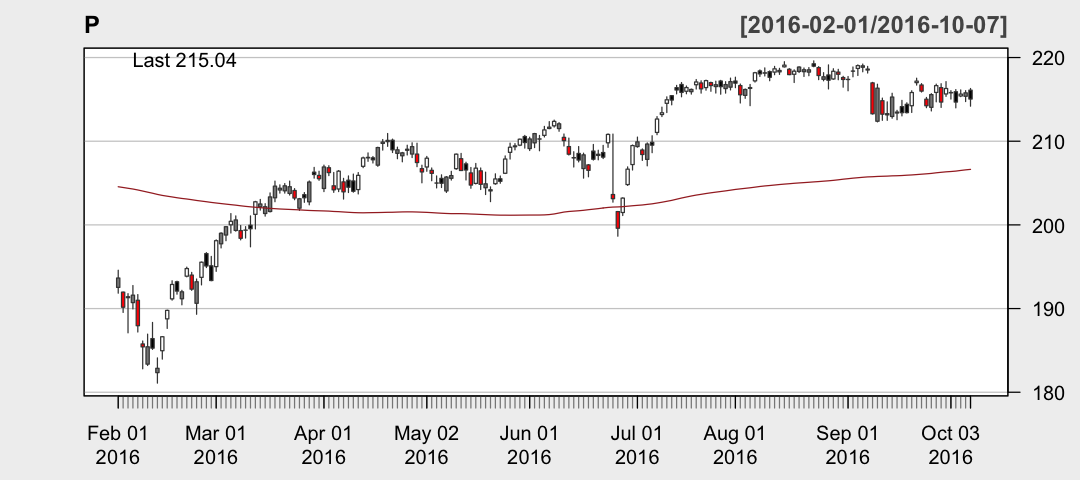

In [4]:
#Bar plot
chartSeries(P, subset="last 9 months", multi.col=TRUE, theme="white", TA="addSMA(n=200)")

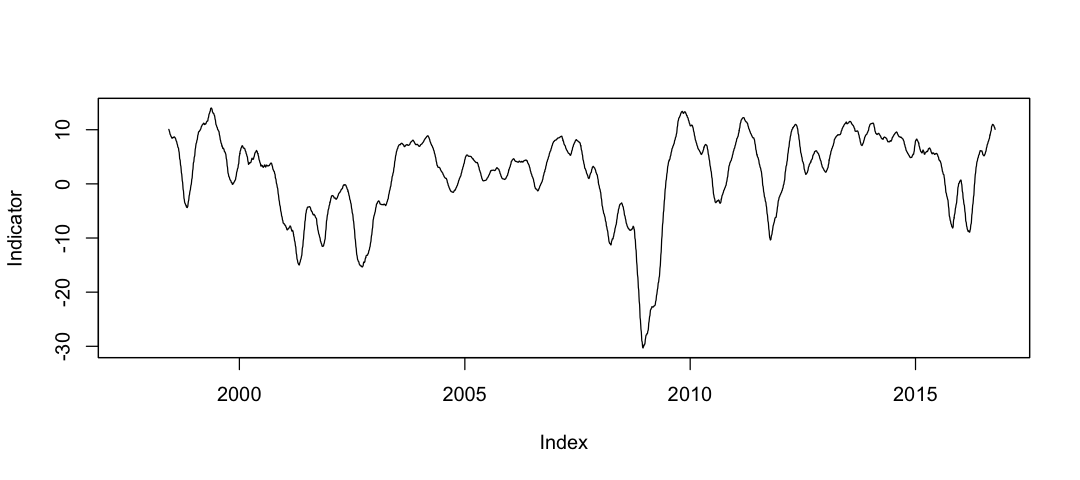

In [5]:
## Define indicator
Indicator<-MA.Fast - MA.Slow
plot(Indicator)

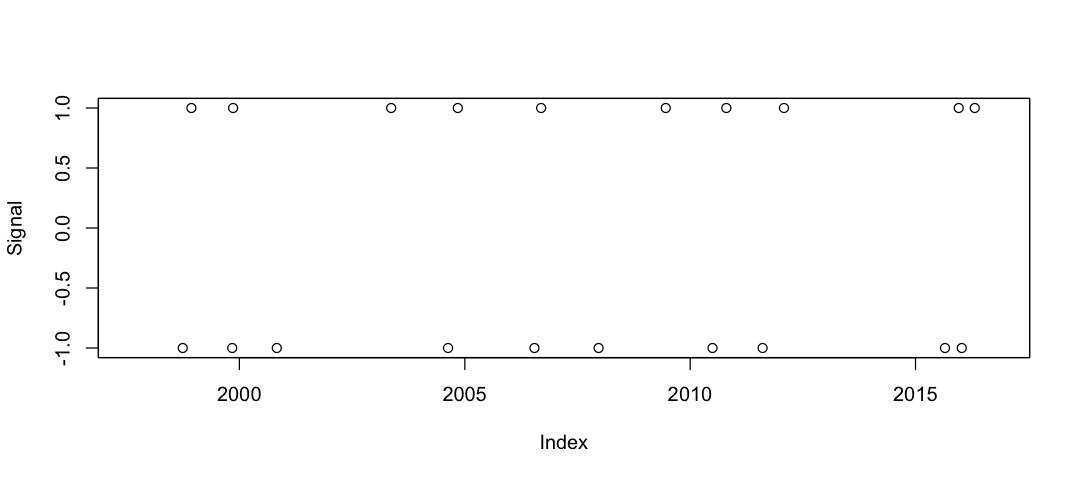

In [6]:
## Define Signal
#Signal<-sign(Indicator)
#plot(Signal))
#plot(Signal$0)
#Signal = xts(Signal)
#plot(index(Signal),Signal$x)

Signal<-NA*Indicator # Create a same size null vector
for (i in 201:length(Indicator)) { #first 200 records is futile as ma is not defined
    if ( as.numeric(Indicator[i-1]) < 0  & as.numeric(Indicator[i]) >= 0 ) {
        Signal[i]<- 1
    } else if ( as.numeric(Indicator[i-1]) > 0  & as.numeric(Indicator[i]) <= 0 ) {
        Signal[i]<- -1
    }
}
plot(Signal, type="p")

#Signal = xts(Signal)
#plot(index(Signal),Signal$x)
Signal<-sign(Indicator)

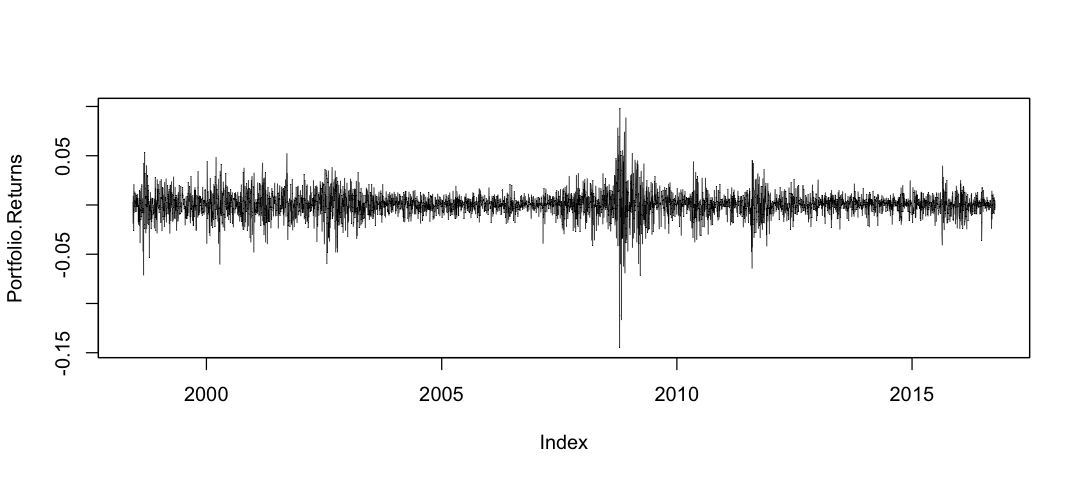

In [7]:
## Define Positions
Positions<-lag(Signal, -1) ##Assumes act on close

## Define Returns
Returns<-Cl(P) / lag( Cl(P), -1 ) -1
Portfolio.Returns<-na.omit(Positions*Returns)

plot(Portfolio.Returns, lwd="0.5")

## Backtesting
### Basic Vectorized Backtesting

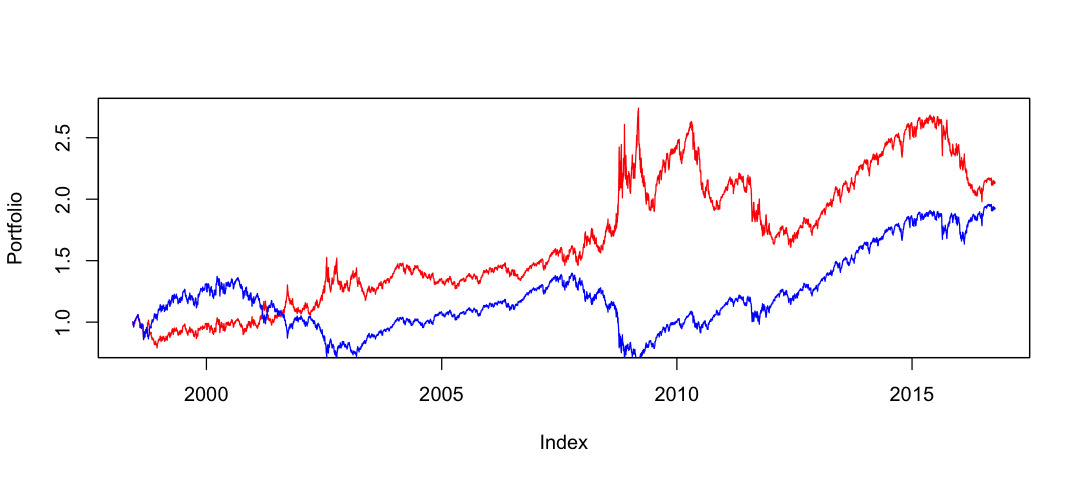

In [8]:
#Calculate portfolio value
Portfolio<-cumprod(1+Portfolio.Returns)

#Calculate buy and hold portfolio
BuyHold.Returns<-window(Returns,time(Portfolio.Returns))
BuyHold<-cumprod(1+BuyHold.Returns)

#Plot Results
#plot(merge(BuyHold, Port), screens=1, col=1:2)

plot(Portfolio, col="red", lwd=1)
lines(BuyHold, col="blue", lwd=1)

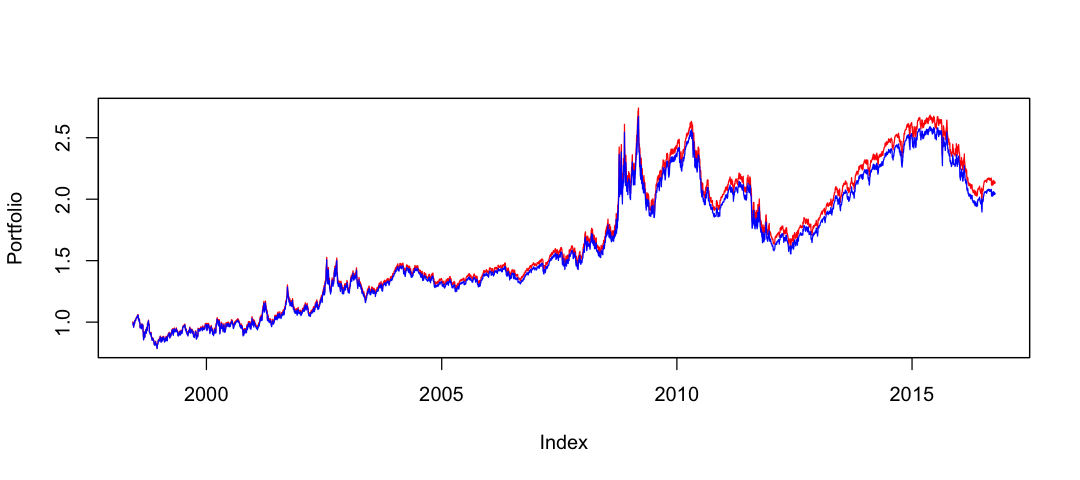

In [9]:
##Add transaction costs
Portfolio.Returns.2<-na.omit(Positions*Returns - abs(diff(Positions))*0.0010)

#calculate portfolio value
Portfolio.2<-cumprod(1 + Portfolio.Returns.2)

#Plot Results
plot(Portfolio, col="red", lwd=1)
lines(Portfolio.2, col="blue", lwd=1) # with transaction costs

## Strategy Testing in Blotter

In [10]:
ls(all=T) # list objects

[1] ".blotter"            ".pbd_env"            "BuyHold"            
 [4] "BuyHold.Returns"     "Indicator"           "MA.Fast"            
 [7] "MA.Slow"             "P"                   "Portfolio"          
[10] "Portfolio.2"         "Portfolio.Returns"   "Portfolio.Returns.2"
[13] "Positions"           "Returns"             "Signal"             
[16] "i"

In [11]:
# Initialize a currency
currency("USD")

[1] "USD"

In [12]:
stock("BIST", currency="USD", multiplier=1)

[1] "BIST"

In [13]:
ls(envir=FinancialInstrument:::.instrument)
# Instrument objects are stored in the .instrument environment of FinancialInstrument

[1] "BIST" "USD"

In [14]:
get("USD", envir=FinancialInstrument:::.instrument)

primary_id :"USD"
currency   :"USD"
multiplier :1
tick_size  :0.01
identifiers: list()
type       :"currency"

In [15]:
get("BIST", envir=FinancialInstrument:::.instrument)

primary_id :"BIST"
currency   :"USD"
multiplier :1
tick_size  :0.01
identifiers: list()
type       :"stock"

In [16]:
Sys.setenv(TZ="UTC") # Set timezone to GMT

In [17]:
BIST<-Quandl("GOOG/INDEXIST_XU100", type="xts") # must be an xts for blotter library

In [18]:
BIST<-na.omit(BIST) # omit the empty days
BIST<-xts(coredata(BIST), as.POSIXct(time(BIST)))

#Define Moving Averages
BIST$MA50 <- SMA(Cl(BIST), 50)
BIST$MA200 <- SMA(Cl(BIST), 200)

In [19]:
## Initialize portfolio and account

my.strategy <- "Golden Cross"
initPortf(my.strategy, 'BIST', initDate="2005-01-01")
initAcct(my.strategy, portfolios=my.strategy, initDate="2005-01-01", initEq=1000000)

[1] "Golden Cross"

[1] "Golden Cross"

In [20]:
ls(.blotter)

[1] "account.Golden Cross"   "portfolio.Golden Cross"

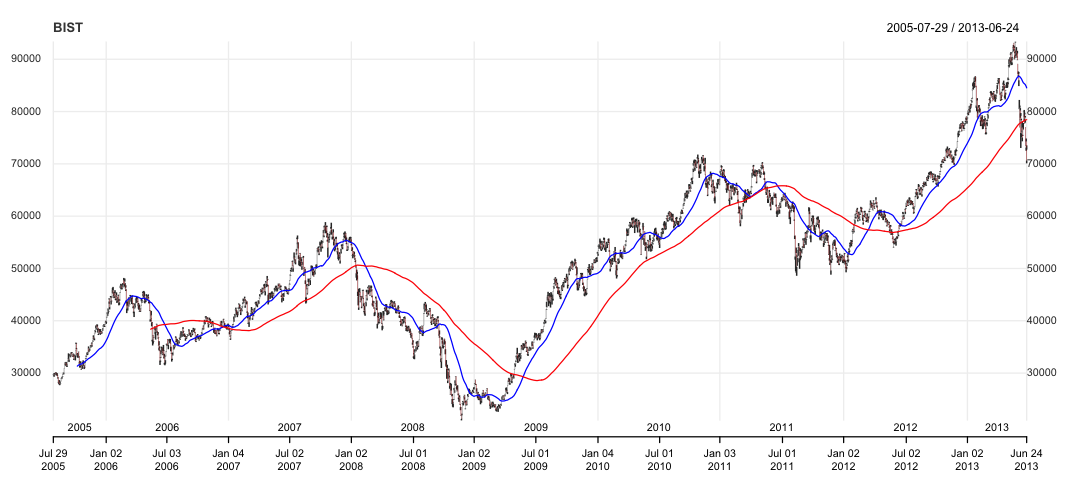

In [21]:
chart_Series(x=BIST,name="BIST", TA="add_SMA(n=50, col=4);add_SMA(n=200, col=2)")

## Iteratively Trading

In [22]:
for ( i in 1:nrow(BIST) ) {
    
    CurrentDate <- time(BIST)[i]
    equity = getEndEq(my.strategy, CurrentDate)
    ClosedPrice <- as.numeric(Cl(BIST[i,]))
    Position <- getPosQty(my.strategy, Symbol="BIST", Date=CurrentDate)
    UnitSize = as.numeric(trunc(equity/ClosedPrice))
    FMA <- as.numeric(BIST[i,'MA50'])
    SMA <- as.numeric(BIST[i,'MA200'])
    
    if ( ! (is.na(FMA) | is.na(SMA) )) {
    if (Position == 0) {
        if (FMA >= SMA) {
            addTxn(my.strategy, Symbol="BIST", TxnDate=CurrentDate, TxnPrice=ClosedPrice, TxnQty = UnitSize, TxnFees=0)
        }
    } else {
        if (FMA < SMA) {
            addTxn(my.strategy, Symbol="BIST", TxnDate=CurrentDate, TxnPrice=ClosedPrice, TxnQty=-Position, TxnFees=0)
        }
    }
    
} else {
    if (i==nrow(BIST)) {
        addTxn(my.strategy, Symbol="BIST", TxnDate=CurrentDate, TxnPrice=ClosedPrice, TxnQty=-Posn,TxnFees=0)
    }
}

updatePortf(my.strategy, Dates=CurrentDate)
updateAcct(my.strategy, Dates=CurrentDate)
updateEndEq(my.strategy, CurrentDate)

}



[1] "2006-05-16 00:00:00 BIST 24 @ 41044.06"
[1] "2006-06-27 00:00:00 BIST -24 @ 32470.42"
[1] "2006-12-15 00:00:00 BIST 19 @ 40204.8"
[1] "2008-02-13 00:00:00 BIST -19 @ 44752.46"
[1] "2009-05-27 00:00:00 BIST 25 @ 35168.73"
[1] "2011-06-17 00:00:00 BIST -25 @ 61716.68"
[1] "2012-03-13 00:00:00 BIST 26 @ 59389.02"


In [23]:
getTxns(Portfolio=my.strategy, Symbol="BIST")

           Txn.Qty Txn.Price Txn.Fees  Txn.Value Txn.Avg.Cost
2005-01-01       0      0.00        0        0.0         0.00
2006-05-16      24  41044.06        0   985057.4     41044.06
2006-06-27     -24  32470.42        0  -779290.1     32470.42
2006-12-15      19  40204.80        0   763891.2     40204.80
2008-02-13     -19  44752.46        0  -850296.7     44752.46
2009-05-27      25  35168.73        0   879218.3     35168.73
2011-06-17     -25  61716.68        0 -1542917.0     61716.68
2012-03-13      26  59389.02        0  1544114.5     59389.02
           Net.Txn.Realized.PL
2005-01-01                0.00
2006-05-16                0.00
2006-06-27          -205767.36
2006-12-15                0.00
2008-02-13            86405.54
2009-05-27                0.00
2011-06-17           663698.75
2012-03-13                0.00

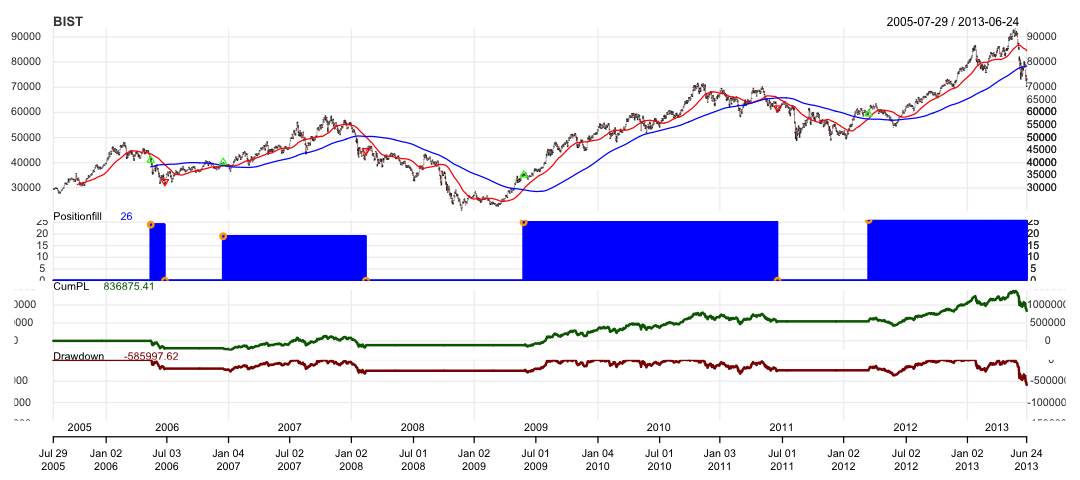

In [24]:
chart.Posn(my.strategy, Symbol= "BIST", TA='add_SMA(n=50, col=2, on=1);add_SMA(n=200, col=4, on=1);')

In [25]:
#initPortf("buyHold", "BIST", initDate="2005-01-01")
#initAcct("buyHold", portfolios="buyHold", initDate="2005-01-01", initEq=1000000)
CurrentDate <- time(getTxns(Portfolio=my.strategy, Symbol="BIST"))[2]
equity = getEndEq("buyHold", CurrentDate)
ClosePrice <- as.numeric(Cl(BIST[CurrentDate,]))
UnitSize = as.numeric(trunc(equity/ClosePrice))
addTxn("buyHold", Symbol="BIST", TxnDate=CurrentDate, TxnPrice=ClosePrice, TxnQty = UnitSize, TxnFees=0)

LastDate <- last(time(BIST))
LastPrice <- as.numeric(Cl(BIST[LastDate,]))
addTxn("buyHold", Symbol="BIST", TxnDate=LastDate, TxnPrice=LastPrice, TxnQty=-UnitSize, TxnFees=0)
updatePortf(Portfolio="buyHold")
updateAcct(name="buyHold")
updateEndEq(Account="buyHold")

ReturnsGC <- PortfReturns(Account="Golden Cross")
ReturnsBH <- PortfReturns(Account="buyHold")
rettable <- cbind(ReturnsGC, ReturnsBH)
colnames(rettable) <- c("GoldenCross", "BuyHold")

ERROR: Error in getEndEq("buyHold", CurrentDate): Account buyHold not found, use initAcct() to create a new account
